In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from time import time

import gprob as gp
from gprob import normal
from gprob.fft import fft

np.random.seed(0)

This notebook shows the application of gprob for the solution of linear Langevin equations, and the causal and non-causal Wiener filtering. It illustrates the usage of vector operations, masked conditioning and Fourier transforms.

# The time-domain solution

The system of Langevin equations we are going to solve is that of a harmonic oscillator damped by viscous force and driven by white noise,
\begin{align*}
&\frac{dp(t)}{dt}=-\Omega_m x(t) + f_p(t),\\
&\frac{dx(t)}{dt}=\Omega_m p(t) - \Gamma_m x(t) + f_x(t).
\end{align*}
Here, $x(t)$ and $p(t)$ are the position and momentum of the oscillator, $\Omega_m$ and $\Gamma_m$ are its resonance frequency and damping rate, and $f_x(t)$ and $f_p(t)$ are the random forces acting on its position and momentum. (An oscillator like a mechanical pendulum would typically have only $f_p$, but $f_x$ also exists for some more abstract oscillators, such as atomic spins. It is given here mainly to keep the illustration of the numerical solution below more general.)

To solve the system of the Langevin equations, it is convenient to represent it in the vector form,

\begin{align*}
&\frac{d\vec{x}(t)}{dt}=\mathbf{A}\,\vec{x}(t)+\vec{f}(t),&

&\text{where}&

&\vec{x}(t)=\begin{pmatrix}
x(t) \\
p(t)
\end{pmatrix},&

&\vec{f}(t)=\begin{pmatrix}
f_x(t) \\
f_p(t)
\end{pmatrix},&

&\mathbf{A}=
\begin{pmatrix}
-\Gamma_m & \Omega_m \\
-\Omega_m & 0
\end{pmatrix}.
\end{align*}

The matrix $\mathbf{A}$ will be called system matrix. The solution is expressed using the Green's function $\mathbf{G}$ as
\begin{equation*}
\vec{x}(t)= \mathbf{G}(t,0)\,\vec{x}(0) + \int_{0}^{t}\mathbf{G}(t,t')\vec{f}(t')dt'.
\end{equation*}

$\mathbf{G}(t_2, t_1)$ is a 2 by 2 matrix dependent on two time indices, $t_1$ and $t_2$. It is related to the matrix exponential of the system matrix as
\begin{equation*}
\mathbf{G}(t_2, t_1) = \exp\left(\int_{t_1}^{t_2}\mathbf{A} dt'\right),
\end{equation*}

To find it numerically, however, we will directly compute the solutions of the homogeneous differential equation with the initial coditions $\vec{x}(0)=(1, 0)$ and $\vec{x}(0)=(0, 1)$, and expressed the Green's function between intermediate times using the relation 
\begin{equation*}
\mathbf{G}(t_2, t_1) = \mathbf{G}(t_2, 0)\,\mathbf{G}^{-1}(t_1, 0)
\end{equation*}
where $\mathbf{G}^{-1}(t_1, 0)$ is the inverse matrix of $\mathbf{G}(t_1, 0)$.

As the first step, we find the Green's function using scipy's `odeint`

In [2]:
gamma_m = 0.01  # Damping rate
omega_m = 1  # Resonance frequency

sys_mat = np.array([[-gamma_m, omega_m], 
                    [-omega_m, 0.     ]])

t = np.linspace(0, 200, 2 * 10**3)  # Distretized time

def eqs(y, t):
    return np.dot(sys_mat, y)

y0 = np.eye(*sys_mat.shape)
green = np.stack([sp.integrate.odeint(eqs, y0_, t) for y0_ in y0], axis=-1)

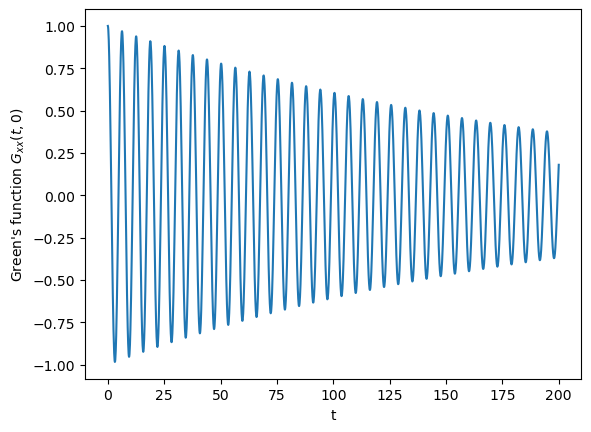

In [3]:
plt.plot(t, green[:, 0, 0])  # Plotting one of the 4 Green's function components
plt.xlabel("t")
plt.ylabel("Green's function $G_{xx}(t, 0)$");

Next, we calculate 
$$\vec{x}_\mathrm{f}=\int_{0}^{t}\mathbf{G}(t,t')\vec{f}(t')dt'=\mathbf{G}(t, 0)\int_{0}^{t}\mathbf{G}^{-1}(t', 0)\vec{f}(t')dt',$$
which is the part of the oscillaor's motion excited by the random force.

In [4]:
green_inv = np.linalg.inv(green) # G^{-1}(t', 0)
f_in = normal(size=(len(t), 2))  # The random fore, f_in = (f_x(t), f_y(t))

tmp = gp.einsum("ikj, ij -> ik", green_inv, f_in)   # G^{-1}(t', 0) @ f_in(t')
tmp2 = gp.cumsum(tmp, axis=0)                       # dt = 1, so this is the same as integral
x_f = gp.einsum("ikj, ij -> ik", green, tmp2)       # G(t, 0) @ int(G^{-1}(t', 0) @ f_in(t'))

Sampling and plotting some trajectories of $x_f$ together with the standard deviation,

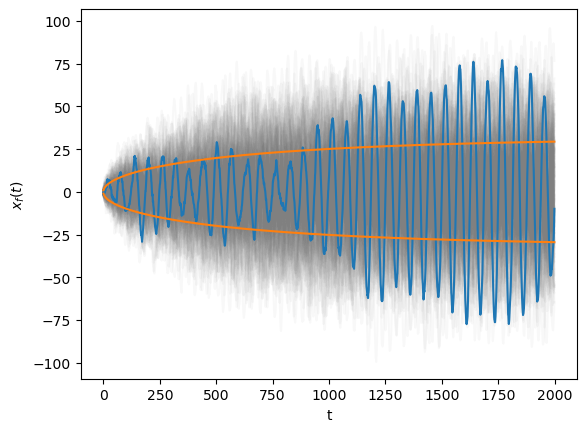

In [5]:
plt.plot(x_f.sample(200)[:, :, 0].T, color='gray', alpha=0.05)
plt.plot(x_f.sample()[:, 0])
plt.plot(np.sqrt(x_f.var()[:, 0]), color="tab:orange")
plt.plot(-np.sqrt(x_f.var()[:, 0]), color="tab:orange")
plt.xlabel("t")
plt.ylabel("$x_f(t)$");

To get the full solution, we add the contribution of the initial condition.

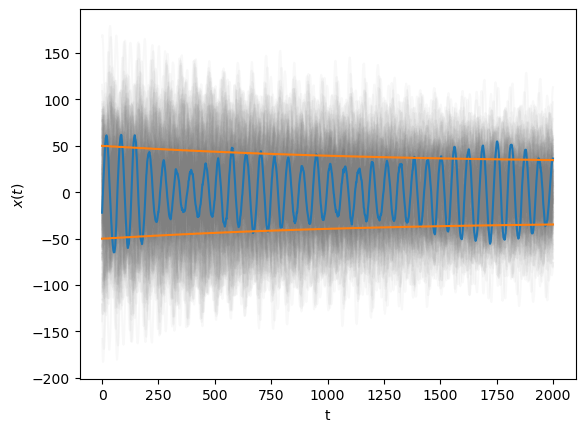

In [6]:
x0 = normal(0, 50**2, size=2)  # The initial consition
x = green @ x0 + x_f

plt.plot(x.sample(200)[:, :, 0].T, color='gray', alpha=0.05)
plt.plot(x.sample()[:, 0])
plt.plot(np.sqrt(x.var()[:, 0]), color="tab:orange")
plt.plot(-np.sqrt(x.var()[:, 0]), color="tab:orange")
plt.xlabel("t")
plt.ylabel("$x(t)$");

The spectrum of the random motion clearly revels a peak at the oscillation frequency,

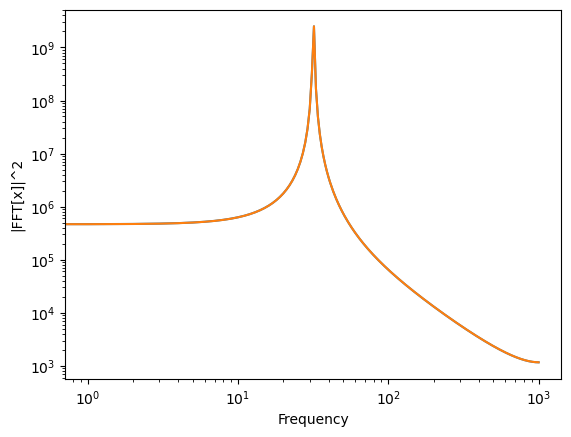

In [7]:
ftx = fft(x, axis=0)

plt.plot(ftx.var()[:len(t)//2])
plt.yscale("log")
plt.xscale("log")

plt.xlabel("Frequency")
plt.ylabel("|FFT[x]|^2");

# Continuous noisy measurements and Wiener filtering

Suppose now that the oscillator position $x(t)$ is imprecisely observed with some detection noise $m(t)$. The reconstruction of the state vector $\vec{x}=(x, p)$ from the noisy observation of $x$ is a task of optimum Wiener or Kalman filtering. Both are equivalent to the calculation of the conditional distribution of $\vec{x}(t)$ given the noisy observations.

To illustrate how measurement noise hides certain features of the motion, here is a comparison of the true and observed signals in the spectral domain

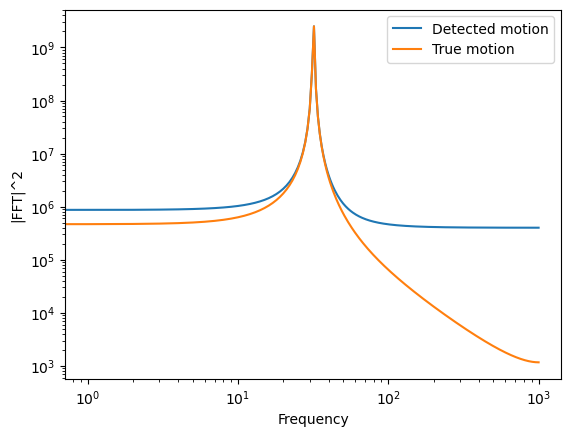

In [8]:
m = normal(0, 200, size=len(t))  # White detection noise.

det = m + x[:, 0]  # The detected signal
ftdet = fft(det, axis=0)

plt.plot(ftdet.var()[:len(t)//2], label="Detected motion")
plt.plot(ftx.var()[:len(t)//2, 0], label="True motion")
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.xlabel("Frequency")
plt.ylabel("|FFT|^2");

Conditioning the oscillator motion on the measurement record,

In [9]:
t_ref = time()
x_cond = x | {det: 0}
print(f"Conditioning time: {time() - t_ref:0.3f} s")

Conditioning time: 4.806 s


Examining the resulting state at the end of the time interval,

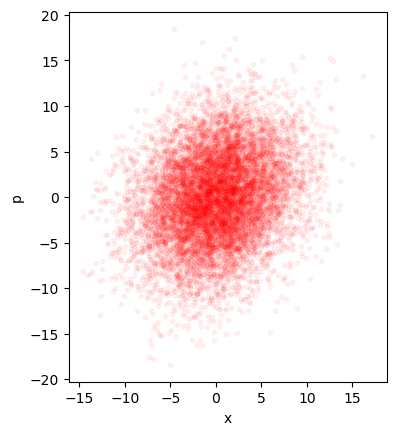

In [10]:
s = x_cond[-1].sample(10**4)
plt.plot(s[:, 0], s[:, 1], 'r.', alpha=0.05)
plt.xlabel("x")
plt.ylabel("p")
plt.gca().set_aspect('equal');

$p$ has a slightly larger variance than $x$, because it is not the variable observed. Comparing the Fourier transforms of the conditional motion, we note that the resonance peaks got broader - this effect is known as damping by measurement.

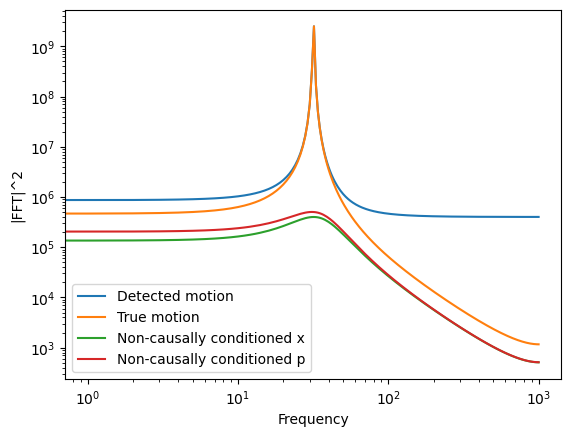

In [11]:
ftx_cond = fft(x_cond, axis=0)

plt.plot(ftdet.var()[:len(t)//2], label="Detected motion")
plt.plot(ftx.var()[:len(t)//2, 0], label="True motion")
plt.plot(ftx_cond.var()[:len(t)//2], label=["Non-causally conditioned x", "Non-causally conditioned p"])
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.xlabel("Frequency")
plt.ylabel("|FFT|^2");

The conditioning above used all observations for all $x(t)$ regardless of whether the observations came earlier or later than $t$. Another problem is conditioning $x(t)$ on observations only from times earlier than $t$, or observations only from times later than $t$. Those are the problems of *causal* and *anti-causal* filterings, respectively.

A causal or anti-causal constraint can be added to the conditioning via masks, as shown below

In [12]:
n = len(t)
cmask = np.tri(len(t), len(t), dtype=bool).T  # Causal mask

t_ref = time()
x_caus_cond = x.condition({det: 0}, mask=cmask)  # Causally conditioned x
print(f"Conditioning time: {time() - t_ref:0.3f} s")

Conditioning time: 4.721 s


In [13]:
amask = np.tri(len(t), len(t), -1, dtype=bool)  # Anti-causal mask

t_ref = time()
x_acaus_cond = x.condition({det: 0}, mask=amask)    # Anti-causally conditioned x
print(f"Conditioning time: {time() - t_ref:0.3f} s")

Conditioning time: 6.166 s


We can see the difference between the variances of the fully and causally conditioned states,

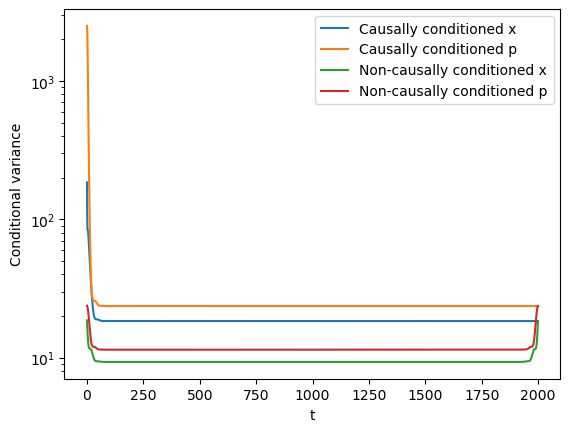

In [14]:
plt.plot(x_caus_cond.var(), label=["Causally conditioned x", "Causally conditioned p"])
plt.plot(x_cond.var(), label=["Non-causally conditioned x", "Non-causally conditioned p"])
plt.yscale("log")
plt.legend()

plt.xlabel("t")
plt.ylabel("Conditional variance");

and the difference between the variances of the fully and anti-causally conditioned states

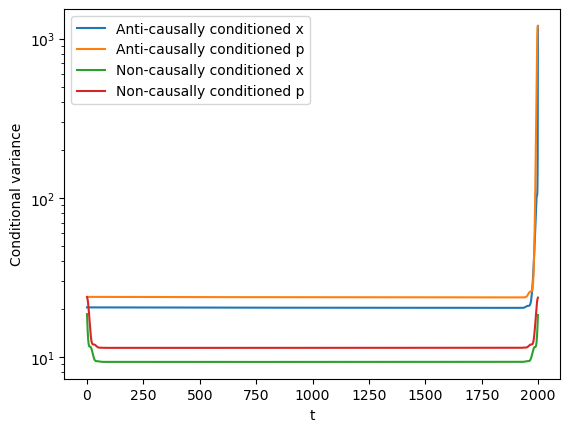

In [15]:
plt.plot(x_acaus_cond.var(), label=["Anti-causally conditioned x", "Anti-causally conditioned p"])
plt.plot(x_cond.var(), label=["Non-causally conditioned x", "Non-causally conditioned p"])
plt.yscale("log")
plt.legend()

plt.xlabel("t")
plt.ylabel("Conditional variance");

Finally, we compare the Fourier spectra of the causally conditioned motion and the true unconditional motion of the oscillator,

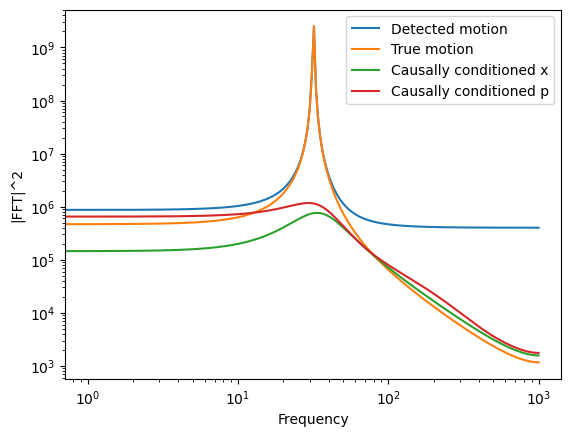

In [16]:
ftx_caus_cond = fft(x_caus_cond, axis=0)

plt.plot(ftdet.var()[:len(t)//2], label="Detected motion")
plt.plot(ftx.var()[:len(t)//2, 0], label="True motion")
plt.plot(ftx_caus_cond.var()[:len(t)//2], label=["Causally conditioned x", "Causally conditioned p"])
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.xlabel("Frequency")
plt.ylabel("|FFT|^2");